# Does everything to run entropy and creates slurm files to submit for AT2

Goal is 4 chains k=2-7.

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
root = '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2'

In [4]:
cd $root

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2


### Create mgpl & pntest files with associated dir 

In [5]:
ent_dir =os.path.join(root,'entropy')
assert ent_dir

In [6]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy


In [7]:
!gunzip 'good_snps.recode.vcf.gz'

In [8]:
vcf = 'good_snps.recode.vcf'
vcf

'good_snps.recode.vcf'

In [9]:
perl_mpgl = '/data/gpfs/home/tfaske/g/src/perl_scripts/vcf2mpgl_milkweed.pl'
perl_mean = '/data/gpfs/home/tfaske/g/src/perl_scripts/gl2genest_milkweed.pl'

In [10]:
!perl $perl_mpgl $vcf

Number of loci: 45387; number of individuals 227


In [11]:
mpgl = 'good_snps.recode.mpgl'

In [12]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [13]:
%load_ext rpy2.ipython

In [14]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)
require(ggsci)
require(patchwork)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy')

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: LEA

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggsci

R[write to console]: Loading required package: patchwork

R[write to console]: 
Attaching package: ‘patchwork’


R[write to console]: The following object is masked from ‘package:MASS’:

    area




In [15]:
%%R
#create Pop_ID file 

indv<-read.table("../filtering/good_snps.recode.vcf.012.indv",sep="\t")

Sp <- rep(NA,times=nrow(indv))
Ploidy <- rep(NA,times=nrow(indv))
Pop <- rep(NA,times=nrow(indv))
ID <- rep(NA,times=nrow(indv))
All <- rep(NA,times=nrow(indv))
for (i in 1:nrow(indv)){
  SpP <- unlist(strsplit(as.character(indv$V1[i]),"_"))[1]
  Sp[i] <- gsub('\\d','',SpP,perl=TRUE)
  Ploidy[i] <-  gsub('(\\D)','',SpP,perl=TRUE)
  Pop[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[2]
  ID[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[3]
  All[i] <- as.character(indv$V1[i])
}
Pop_ID <- data.frame(Sp=Sp,Ploidy=Ploidy,Pop=Pop,ID=ID,All=All,
                     SpPloidy=paste0(Sp,Ploidy))

print(head(Pop_ID))

write.csv(Pop_ID,"Pop_ID.csv",row.names = FALSE)

  Sp Ploidy Pop ID       All SpPloidy
1 AT      2  BB 10 AT2_BB_10      AT2
2 AT      2  BB 11 AT2_BB_11      AT2
3 AT      2  BB 12 AT2_BB_12      AT2
4 AT      2  BB 13 AT2_BB_13      AT2
5 AT      2  BB 14 AT2_BB_14      AT2
6 AT      2  BB 15 AT2_BB_15      AT2


In [16]:
%%R
g <- read.table("pntest_mean_good_snps.recode.txt", header=F)
dim(g)

[1] 45387   227


In [17]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.05120 0.02868 0.01764 0.01153 0.01042 


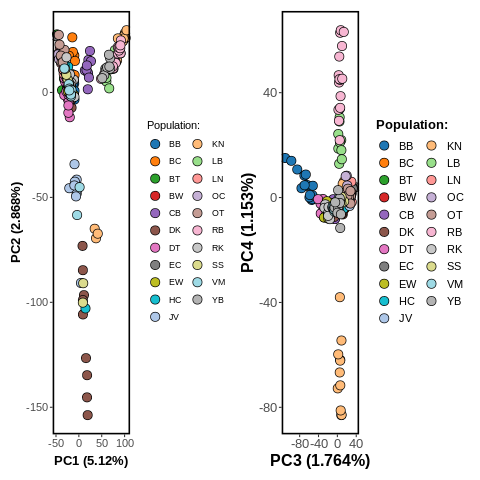

In [18]:
%%R
pca_df <- cbind(pca_df[,1:10],Pop_ID)

col21 <- c(pal_d3(palette = 'category20')(20)[1:20],'grey70')
pca12_pop <- ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=as.character(Pop))) +
  geom_point(pch=21,colour='black',size = 4) + 
  xlab(paste("PC",1," (",0.05120*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.02868*100,"%)",sep=""))  +
  scale_fill_manual(name = 'Population:',values = col21) +
  theme_bw() + 
  theme(#legend.position = 'none',
    axis.text = element_text(size=11), 
    axis.title = element_text(size = 13, colour="black",face = "bold",vjust = 1),
    panel.border = element_rect(size = 1.5, colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())


pca34_pop <- ggplot(data = pca_df, aes(x=PC3,y=PC4,fill=as.character(Pop))) +
  geom_point(pch=21,colour='black',size = 4) +  
  xlab(paste("PC",3," (",0.01764*100,"%)",sep="")) + 
  ylab(paste("PC",4," (",0.01153*100,"%)",sep="")) +
  scale_fill_manual(name = 'Population:',values = col21) +
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
pca12_pop + pca34_pop

In [19]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [20]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [21]:
!head entropy_header.txt

227 45387                                                                                                                                                                                                                                  
BB_10 BB_11 BB_12 BB_13 BB_14 BB_15 BB_16 BB_17 BB_1 BB_2 BB_3 BB_4 BB_5 BB_6 BB_7 BB_8 BB_9 BC_17 BC_18 BC_19 BC_20 BC_21 BC_22 BC_23 BT_1 BT_2 BT_3 BT_4 BT_57 BT_58 BT_59 BT_5 BT_60 BT_61 BT_62 BT_63 BT_64 BT_6 BT_7 BW_1 BW_65 BW_66 BW_67 BW_68 BW_69 BW_70 BW_71 BW_72 CB_24 CB_25 CB_26 CB_27 CB_28 CB_29 CB_30 CB_31 CB_32 DK_16 DK_17 DK_18 DK_19 DK_20 DK_21 DK_22 DK_23 DK_24 DK_25 DK_26 DK_27 DK_28 DK_29 DK_30 DT_10 DT_11 DT_12 DT_13 DT_14 DT_15 DT_1 DT_2 DT_3 DT_4 DT_5 DT_6 DT_7 DT_8 DT_9 EC_45 EC_46 EC_47 EC_48 EC_49 EC_50 EC_51 EC_52 EC_53 EW_31 EW_32 EW_33 EW_34 EW_35 EW_36 EW_37 EW_39 EW_40 HC_1 HC_2 HC_3 HC_4 HC_5 HC_6 HC_7 HC_8 JV_1 JV_2 JV_37 JV_38 JV_39 JV_3 JV_40 JV_41 JV_42 JV_43 JV_44 JV_4 JV_5 JV_6 JV_7 KN_80 KN_81 KN_82 KN_83 KN_84 KN_85 K

In [22]:
!cat entropy_header.txt good_snps.recode.mpgl > entropy.mpgl

In [23]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy


In [24]:
!mkdir shdir

In [31]:
### select slurm options
#account = 'cpu-s5-denovo-0'
#partition = 'cpu-core-0'
account = 'cpu-s1-bionres-0'
partition = 'cpu-s1-bionres-0'
time = '14-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 2500
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7]
chains = 4

In [37]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [38]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [39]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/entropy/shdir/run_entropy

In [40]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [41]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/milkweed/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [130]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [131]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/milkweed/entropy


In [132]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k10_c1.hdf5',
 './entropy_k10_c2.hdf5',
 './entropy_k10_c3.hdf5',
 './entropy_k10_c4.hdf5',
 './entropy_k11_c1.hdf5',
 './entropy_k11_c2.hdf5',
 './entropy_k11_c3.hdf5',
 './entropy_k11_c4.hdf5',
 './entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5',
 './entropy_k8_c1.hdf5',
 './entropy_k8_c2.hdf5',
 './entropy_k8_c3.hdf5',
 './entropy_k8_c4.hdf5',
 './entropy_k9_c1.hdf5',
 './entropy_k9_c2.hdf5',
 './entropy_k9_c3.hdf5',
 './entropy_k9_c4

In [133]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [134]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [135]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k10_c4.txt',
 './DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k10_c3.txt',
 './DIC_k3_c2.txt',
 './DIC_k10_c1.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k11_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k8_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k8_c3.txt',
 './DIC_k8_c1.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k8_c2.txt',
 './DIC_k11_c4.txt',
 './DIC_k10_c2.txt',
 './DIC_k9_c3.txt',
 './DIC_k9_c2.txt',
 './DIC_k11_c3.txt',
 './DIC_k11_c1.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k9_c1.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt',
 './DIC_k9_c4.txt']

In [136]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k10_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 3618225.18
Effective number of parameters: 22825096.47
Model DIC: 26443321.66


file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4528543.68
Effective number of parameters: 21865490.07
Model DIC: 26394033.75


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 3800249.08
Effective number of parameters: 6284555.37
Model DIC: 10084804.45


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4529367.01
Effective number of parameters: 20258547.64
Model DIC: 24787914.65


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 3812436.01
Effective number of parameters: 10558602.52
Model DIC: 14371038.53


file = ./entropy_k10_c3.hdf5
parameter dimensions for deviance: sample

In [137]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,10,26443321.66,4
1,2,26394033.75,4
2,7,10084804.45,2
3,2,24787914.65,1
4,6,14371038.53,1


In [138]:
dic_df.to_csv('dic_list.csv')

In [139]:
dic_sum = dic_df.groupby('k').describe().DIC

In [140]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
9,4.0,9.55184255e+06,7.49730784e+05,8601329.03,9331061.7275,9585423.455,9.80620428e+06,10435194.26
8,4.0,1.04513769e+07,1.39197540e+06,9405143.19,9645082.9125,9959114.870,1.07654088e+07,12482134.64
7,4.0,1.05548975e+07,6.94328471e+05,10084804.45,10137248.8675,10279445.790,1.06970944e+07,11575893.79
4,4.0,1.33756190e+07,2.90022785e+06,9771310.70,11940431.4725,13548673.225,1.49838608e+07,16633819.04
3,4.0,1.55462262e+07,1.72792615e+06,14309604.75,14351154.1875,14936609.495,1.61316815e+07,18002081.03
6,4.0,1.72543732e+07,2.98169179e+06,14371038.53,15759170.5400,16620216.150,1.81154188e+07,21406021.93
10,4.0,1.96009989e+07,9.17231016e+06,9529484.61,13019289.8925,20312939.990,2.68946490e+07,28248631.06
2,4.0,2.28448291e+07,3.53733500e+06,18354672.01,20970689.9200,23315305.270,2.51894444e+07,26394033.75
11,4.0,2.66840567e+07,1.73946347e+07,13482940.75,14367470.1025,21160482.475,3.34770691e+07,50932321.25


In [141]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [142]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt

!$estpost *k9*.hdf5 -p q -s 0 -o q9.txt

!$estpost *k10*.hdf5 -p q -s 0 -o q10.txt

!$estpost *k11*.hdf5 -p q -s 0 -o q11.txt


file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 143, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 143, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 143, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 143, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 143, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

In [143]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

!$estpost *k9*.hdf5 -p q -s 4 -o MCMC_k9.txt

!$estpost *k10*.hdf5 -p q -s 4 -o MCMC_k10.txt

!$estpost *k11*.hdf5 -p q -s 4 -o MCMC_k11.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 143, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 143, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 143, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 143, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 143, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

### make slurm script to make gprob file

    use all k and chains to make gprob

In [147]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/milkweed/entropy


In [162]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,6,7,8,9,10,11]

In [168]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [169]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [170]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k10.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k11.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k2.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k3.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k4.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k5.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k6.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k7.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k8.sh',
 '/data/gpfs/home/tfaske/d/milkweed/entropy/shdir/run_gprob_k9.sh']

In [171]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [172]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [180]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5',
 '../entropy_k8_c*hdf5',
 '../entropy_k9_c*hdf5',
 '../entropy_k10_c*hdf5',
 '../entropy_k11_c*hdf5']

In [181]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 ../entropy_k8_c*hdf5 ../entropy_k9_c*hdf5 ../entropy_k10_c*hdf5 ../entropy_k11_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [182]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [183]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [184]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/milkweed/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt